In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.layers import Dropout
from keras.engine.sequential import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam, SGD

In [18]:
data_path = 'data/201709-202201.csv'
data = pd.read_csv(data_path)
data = data[(data['timestamp'] >= '2018-08-22') & (data['timestamp'] <= '2019-05-13')]
data = data.drop(['Unnamed: 0', 'timestamp'], axis=1)

data.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count,MACD,SMA,OBV,RSI,MFI,vader_pos,vader_neg,vader_neu,vader_compound,pos_count,neg_count,neu_count
355,6478.99,6906.81,6250.00,6355.76,11955.650696,32584,424.686973,6395.424,-284396.446464,47.641124,16.223392,0.096737,0.086697,0.816525,0.067605,47,38,14
356,6355.97,6575.99,6344.80,6525.01,4028.433872,15436,438.188397,6420.570,-280368.012591,47.638130,75.326854,0.109176,0.064637,0.826127,0.157476,52,26,24
357,6525.99,6721.09,6445.32,6692.94,6374.542579,21727,451.584523,6462.760,-273993.470013,47.621469,80.466872,0.114455,0.053475,0.832101,0.213056,58,19,22
358,6692.99,6800.00,6664.25,6732.40,4980.647403,14202,454.732329,6557.076,-269012.822610,46.218201,71.189787,0.125371,0.053295,0.821343,0.213161,57,23,25
359,6732.99,6775.34,6558.95,6700.46,3475.720250,11261,452.184409,6601.314,-272488.542859,47.737706,77.353938,0.132510,0.039663,0.827806,0.255805,60,16,22


In [19]:
'''Price Data:'''
# data_features = data.drop(['price_close', 'MACD', 'SMA', 'OBV', 'RSI', 'MFI', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator:'''
data_features = data.drop(['price_close', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Sentiment Indicator:'''
# data_features = data.drop(['price_close', 'MACD', 'SMA', 'OBV', 'RSI', 'MFI', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator + Sentiment Indicator:'''
# data_features = data.drop(['price_close', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator in 30 MIN data:'''
# data_features = data.drop(['price_close', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count', 'pos_keywords_occur', 'neg_keywords_occur'], axis=1)

data_labels = data['price_close']

scaler_feature = MinMaxScaler(feature_range=(0, 1))
scaler_label = MinMaxScaler(feature_range=(0, 1))

feature = scaler_feature.fit_transform(data_features.to_numpy())
label = scaler_label.fit_transform(data_labels.to_numpy().reshape(-1, 1))





In [20]:
def split_data(f, l, delay):
    feature, label = [], []

    for i in range(len(f) - delay):
        feature.append(f[i: i + delay])
        label.append(l[i + delay-1])
        
    return np.array(feature), np.array(label).squeeze()

LSTM_window_size = 20

feature, label = split_data(feature, label, LSTM_window_size)

train_size = int(0.8 * len(label))

X_train, X_test = feature[:train_size], feature[train_size:]
y_train, y_test = label[:train_size], label[train_size:]

print(X_train.shape, X_test.shape)

(196, 20, 10) (49, 20, 10)


In [21]:
model = \
    keras.Sequential([
        layers.LSTM(512),
        layers.Dense(1)
    ])


In [22]:
EPOCHS = 25
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
DECAY_RATE = -0.6

def lr_scheduler(epoch, lr):
    if epoch % 10== 0 and epoch > 0:
        lr *= tf.math.exp(DECAY_RATE)
    
    return lr

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(X_train, y_train, 
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS, 
                shuffle=False,
                )

Epoch 1/25
2/2 [==============================] - 1s 8ms/step - loss: 0.1981 - root_mean_squared_error: 0.4451
Epoch 2/25
2/2 [==============================] - 0s 7ms/step - loss: 0.1292 - root_mean_squared_error: 0.3594
Epoch 3/25
2/2 [==============================] - 0s 7ms/step - loss: 0.0124 - root_mean_squared_error: 0.1112
Epoch 4/25
2/2 [==============================] - 0s 7ms/step - loss: 0.0389 - root_mean_squared_error: 0.1973
Epoch 5/25
2/2 [==============================] - 0s 7ms/step - loss: 0.0256 - root_mean_squared_error: 0.1601
Epoch 6/25
2/2 [==============================] - 0s 8ms/step - loss: 0.0101 - root_mean_squared_error: 0.1006
Epoch 7/25
2/2 [==============================] - 0s 8ms/step - loss: 0.0066 - root_mean_squared_error: 0.0814
Epoch 8/25
2/2 [==============================] - 0s 8ms/step - loss: 0.0087 - root_mean_squared_error: 0.0933
Epoch 9/25
2/2 [==============================] - 0s 8ms/step - loss: 0.0064 - root_mean_squared_error: 0.0797
E

In [23]:
pred_LSTM = model.predict(X_test)

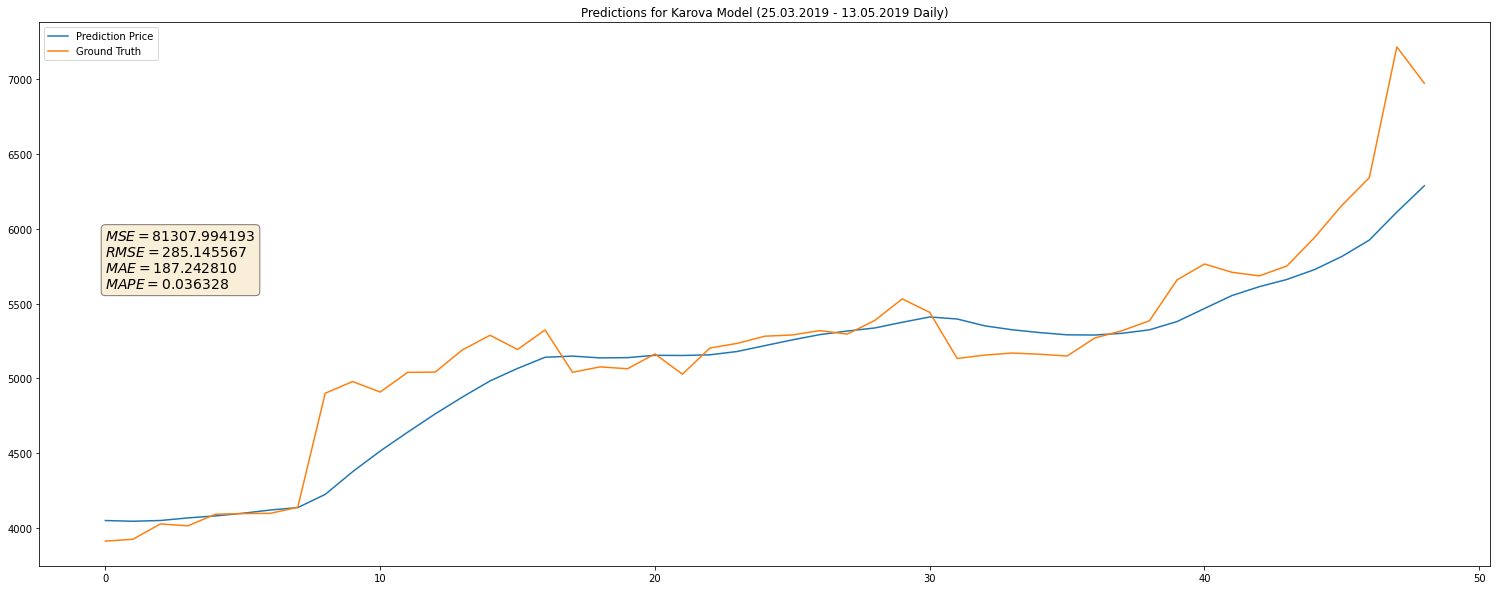

In [26]:
prediction = np.array(pred_LSTM)
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test.reshape(-1,1))

mse = mean_squared_error(pred_prices, true_prices)
rmse = mean_squared_error(pred_prices, true_prices, squared=False)
mae = mean_absolute_error(pred_prices, true_prices)
mape = mean_absolute_percentage_error(pred_prices, true_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae),
    '$MAPE=%f$' % (mape)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('Predictions for Karova Model (25.03.2019 - 13.05.2019 Daily)')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 6000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()